# Поиск аномалий / выбросов



На примере датасета, содержащего характеристики 10000 квартир, сравним четыре метода обнаружения аномальных значений из библиотеки scikit-learn. Аномалии будем искать только по трем признакам: `Square`, `LifeSquare` и `KitchenSquare` (для более простой визуализации). Далее посмотрим, как выглядят аномалии на 3d графике, если их искать по всем признакам (используя PCA). И завершим исследование построением предсказательной модели без учета найденных аномалий и с их учетом.

Документация - https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html?highlight=anomaly 


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подключение-библиотек-и-скриптов" data-toc-modified-id="Подключение-библиотек-и-скриптов-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подключение библиотек и скриптов</a></span></li><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Приведение-типов" data-toc-modified-id="Приведение-типов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Приведение типов</a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обработка пропусков</a></span></li><li><span><a href="#Замена-выбросов,-выявленных-визуально" data-toc-modified-id="Замена-выбросов,-выявленных-визуально-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Замена выбросов, выявленных визуально</a></span></li></ul></li><li><span><a href="#Поиск-аномалий.-Сравнение-четырех-алгоритмов" data-toc-modified-id="Поиск-аномалий.-Сравнение-четырех-алгоритмов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Поиск аномалий. Сравнение четырех алгоритмов</a></span></li><li><span><a href="#Использование-Isolation-Forest-при-построении-прогнозной-модели" data-toc-modified-id="Использование-Isolation-Forest-при-построении-прогнозной-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Использование Isolation Forest при построении прогнозной модели</a></span><ul class="toc-item"><li><span><a href="#Визуализация-результатов-обнаружения-аномалий" data-toc-modified-id="Визуализация-результатов-обнаружения-аномалий-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Визуализация результатов обнаружения аномалий</a></span></li><li><span><a href="#Построение-предсказательной-модели" data-toc-modified-id="Построение-предсказательной-модели-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Построение предсказательной модели</a></span><ul class="toc-item"><li><span><a href="#Построение-базовой-модели" data-toc-modified-id="Построение-базовой-модели-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Построение базовой модели</a></span></li><li><span><a href="#Построение-модели-с-использованием-результатов-обнаружения-аномалий" data-toc-modified-id="Построение-модели-с-использованием-результатов-обнаружения-аномалий-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Построение модели с использованием результатов обнаружения аномалий</a></span></li></ul></li></ul></li></ul></div>

## Подключение библиотек и скриптов

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go

In [2]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_rows', 50)

## Загрузка датасета

In [3]:
TRAIN_DATASET_PATH = '../../Kurs_project_task/train.csv'
TEST_DATASET_PATH = '../../Kurs_project_task/test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train.head()

DistrictId  Rooms  Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                   
14038          35 2.0000 47.9816     29.4428         6.0000      7   
15053          41 3.0000 65.6836     40.0495         8.0000      7   
4765           53 2.0000 44.9480     29.1976         0.0000      8   
5809           58 2.0000 53.3530     52.7315         9.0000      8   
10783          99 1.0000 39.6492     23.7762         7.0000     11   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
Id                                                                      
14038      9.0000       1969     0.0890         B         B        33   
15053      9.0000       1978     0.0001         B         B        46   
4765      12.0000       1968     0.0496         B         B        34   
5809      17.0000       1977     0.4379         B         B        23   
10783     12.0000       1976     0.0123         B         B        35   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
Id                                                                      
14038      7976         5           nan            0       11       B   
15053     10309         1      240.0000            1       16       B   
4765       7759         0      229.0000            1        3       B   
5809       5735         3    1,084.0000            0        5       B   
10783      5776         1    2,078.0000            2        4       B   

             Price  
Id                  
14038 184,966.9307  
15053 300,009.4501  
4765  220,925.9085  
5809  175,616.2272  
10783 150,226.5316

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры (целевая переменная)

In [5]:
train.shape

(10000, 19)

## Предобработка данных

### Приведение типов

In [6]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train[feature_bin_names] = train[feature_bin_names].replace({'A':0, 'B':1})

### Обработка пропусков

In [7]:
train.isna().sum()[train.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [8]:
train.loc[train['LifeSquare'].isna(), 'LifeSquare'] = \
    train['Square'] - train['KitchenSquare']

### Замена выбросов, выявленных визуально

**Square**

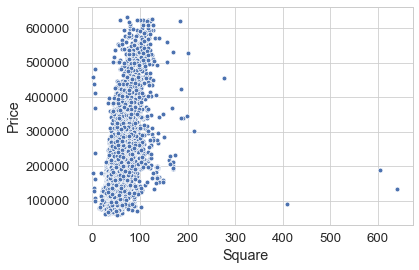

In [9]:
sns.scatterplot(train['Square'], train['Price']);

Заменим медианой значения > 300

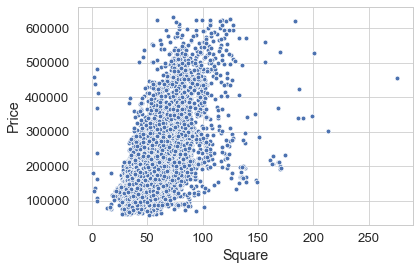

In [10]:
train.loc[train['Square'] > 300, 'Square'] = train['Square'].median()
sns.scatterplot(train['Square'], train['Price']);

**KitchenSquare**

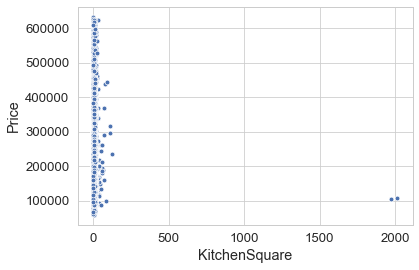

In [11]:
sns.scatterplot(train['KitchenSquare'], train['Price']);

Заменим медианой значения > 40

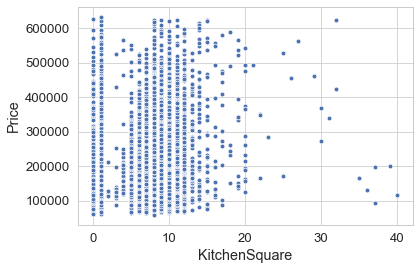

In [12]:
train.loc[train['KitchenSquare'] > 40, 'KitchenSquare'] = train['KitchenSquare'].median()
sns.scatterplot(train['KitchenSquare'], train['Price']);

**LifeSquare**

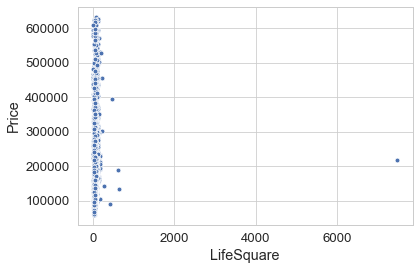

In [13]:
sns.scatterplot(train['LifeSquare'], train['Price']);

Заменим медианой значения > 250

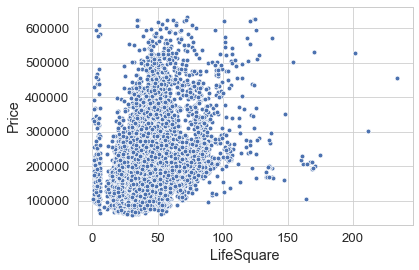

In [14]:
train.loc[train['LifeSquare'] > 250, 'LifeSquare'] = train['LifeSquare'].median()
sns.scatterplot(train['LifeSquare'], train['Price']);

Построим 3d график для трех признаков `Square`, `LifeSquare` и `KitchenSquare`. Цветом укажем стоимость каждой квартиры.

In [15]:
fig = go.Figure(data=[go.Scatter3d(
    x=train['Square'],
    y=train['LifeSquare'],
    z=train['KitchenSquare'], 
    mode='markers',
    marker=dict(
        size=5,
        color=train['Price'], 
        colorscale='jet',  
        colorbar=dict(thickness=10),
        line=dict(width=2, color='DarkSlateGrey')
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Square',
        yaxis_title='LifeSquare',
        zaxis_title='KitchenSquare'),
    )

fig.show()

Screenshot 1
<img src="screenshot_1.png" alt="Screenshot 1" style="width: 600px;"/>

## Поиск аномалий. Сравнение четырех алгоритмов

Сравним работу четырех алгоритмов:

- One-class SVM
- Robust covariance
- Isolation Forest 
- Local Outlier Factor 

Обучим алгоритмы на трех признаках, описывающих площади квартиры. Зададим долю аномалий для поиска - 10%. Результат поиска представим на графиках.

In [16]:
X = train[['Square', 'KitchenSquare', 'LifeSquare']]
outliers_fraction = 0.1

anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction, 
                                           random_state=42)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(contamination=outliers_fraction))
]

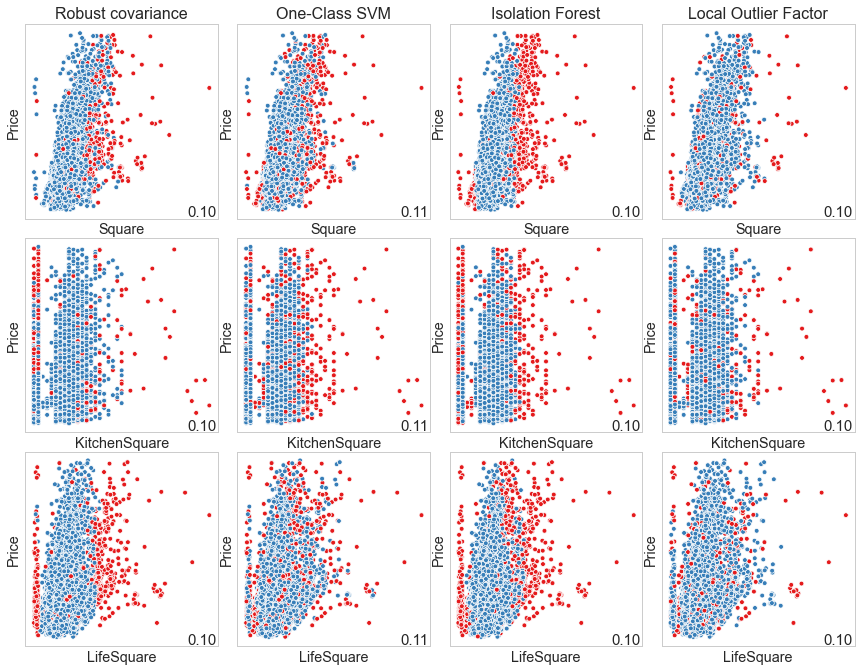

In [17]:
feature_names = ['Square', 'KitchenSquare', 'LifeSquare']

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 9))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, 
                    wspace=.1, hspace=.1)

plot_num = 1

for i, f in enumerate(feature_names):
    for name, algorithm in anomaly_algorithms:
        plt.subplot(len(feature_names), len(anomaly_algorithms), plot_num)
        if i == 0:
            plt.title(name, size=16)
        outliers = algorithm.fit_predict(X)
        sns.scatterplot(train[f], train['Price'], hue=outliers, palette='Set1', legend=False);
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2f' % (len(outliers[outliers == -1]) / len(outliers))),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

Красными точками показаны аномальные значения. Если смотреть на то, как модель определяла квартиры с близкими к нулю значениями площади и с максимальными площадями, то лучше всего с поиском аномалий справилась модель Isolation Forest. Исследуем ее более подробно. Построим 3d график, на котором покажем обнаруженные аномалии.

In [19]:
iforest = IsolationForest(contamination=outliers_fraction, random_state=42)

outliers = iforest.fit_predict(X)
train['Outlier'] = outliers

In [21]:
fig = go.Figure(data=[go.Scatter3d(
    x=train['Square'],
    y=train['LifeSquare'],
    z=train['KitchenSquare'], 
    mode='markers',
    marker=dict(
        size=5,
        color=train['Outlier'], 
        colorscale='rdylbu',  
        line=dict(width=2, color='DarkSlateGrey')
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Square',
        yaxis_title='LifeSquare',
        zaxis_title='KitchenSquare'),
)

fig.show()


Screenshot 2
<img src="screenshot_2.png" alt="Screenshot 2" style="width: 600px;"/>

## Использование Isolation Forest при построении прогнозной модели

### Визуализация результатов обнаружения аномалий

Метод Isolation Forest основан на утверждении, что аномальным объектам свойственно оказываться в листьях с низкой глубиной дерева. А для разбиения нормальных данных дереву потребуется построить
ещё несколько уровней.

In [22]:
iforest = IsolationForest(contamination=outliers_fraction, random_state=42)
iforest

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

Выполним предобработку данных.

In [23]:
train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']
train[feature_bin_names] = train[feature_bin_names].replace({'A':0, 'B':1})
train.loc[train['LifeSquare'].isna(), 'LifeSquare'] = \
    train['Square'] - train['KitchenSquare']

Будем использовать для поиска аномалий все признаки, за исключением признака с пропусками.

In [24]:
X = train.drop(['Healthcare_1'], axis=1)
X.shape

(10000, 18)

In [25]:
outliers = iforest.fit_predict(X)
train['Outlier'] = outliers

Чтобы увидеть результаты детектирования аномалий моделью на всех признаках, сократим размерность данных до трех компонент методом PCA. 

In [26]:
pca = PCA(n_components=3)  
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_reduce = pca.fit_transform(X_scaled)

In [27]:
X_reduce = np.c_[X_reduce, outliers.reshape(-1,1)]
X_reduce.shape

(10000, 4)

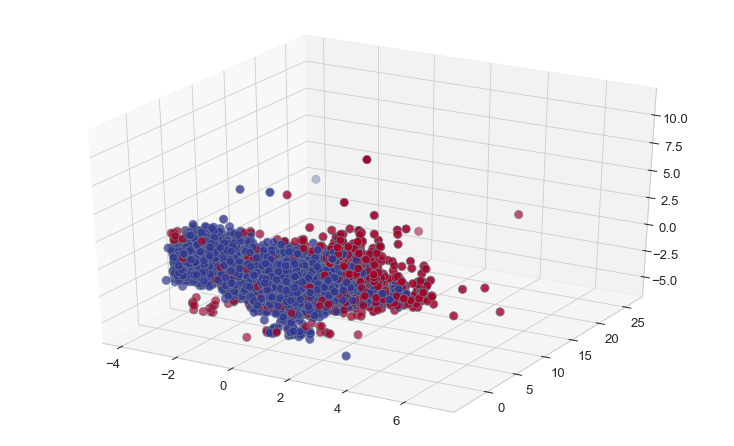

In [30]:
fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) 
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], X_reduce[:, 2], 
           marker='o', c=X_reduce[:, 3], cmap='RdYlBu', s=70, ec='SlateGrey');

Красным цветом показаны аномалии. Видим, что есть пропущенные значения, но их немного. 

Посмотрим результаты на 3d графике.

In [31]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=X_reduce[:, 0],
    y=X_reduce[:, 1],
    z=X_reduce[:, 2], 
    mode='markers',
    marker=dict(
        size=5,
        color=X_reduce[:, 3], 
        colorscale='rdylbu',  
        line=dict(width=2, color='DarkSlateGrey')
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig.show()

Screenshot 3
<img src="screenshot_3.png" alt="Screenshot 3" style="width: 600px;"/>

### Построение предсказательной модели

#### Построение базовой модели

In [32]:
train.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'Outlier'],
      dtype='object')

Отберем признаки, на которых будем обучать модель.

In [33]:
X = train.drop(['DistrictId', 'Healthcare_1', 'Price', 'Outlier'], axis=1)
y = train['Price']
X.shape, y.shape

((10000, 16), (10000,))

Для предсказания используем GradientBoostingRegressor.

In [34]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    n_iter_no_change=10,
    max_depth=8,
    max_features=6,
    random_state=42)

Для проверки точности прогноза используем перекрестную проверку (cross validation) и метрику $R^2$.

In [35]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(gb_model, X, y, scoring='r2', cv=cv)
print('R2: %.4f' % scores.mean()) # R2: 0.7442

R2: 0.7442


#### Построение модели с использованием результатов обнаружения аномалий

Обучим модель на всех данных, включая признак `Outlier`.

In [36]:
X = train.drop(['DistrictId', 'Healthcare_1', 'Price'], axis=1)
X.shape

(10000, 17)

In [37]:
scores = cross_val_score(gb_model, X, y, scoring='r2', cv=cv)
print('R2: %.4f' % scores.mean()) # R2: 0.7503

R2: 0.7541


**Вывод:** Видим, что метрика выросла. Это значит, что результаты детектирования аномалий моделью Isolation Forest не ухудшают качество предсказания градиентного бустинга.

**Что еще можно сделать:**

- подобрать у модели IsolationForest() параметр `contamination` - долю аномалий
- искать аномалии после уменьшения размерности на трех главных компонентах
- проверить итеративный поиск аномалий (1-ая итерация - визуальный поиск, 2-ая - Isolation Forest, 3-я - что-нибудь другое, ...)
- объединить результаты поиска аномалий нескольких моделей путем простого голосования